# Using GPU Clusters for Deep Learning Inference

This demo is meant to show new users how you can get use Dask and GPUs on Saturn Cloud to do fast deep learning inference with your Pytorch based machine learning models. For this example, we'll use an image classification project identifying dog breeds.

### What you'll learn here:

* How to do inference with Pytorch on a prebuilt model
* How to manage resources on your GPU cluster for deep learning inference tasks
* How to run many inference tasks with Pytorch on the GPU cluster
* How to use batch processing to accelerate your inference tasks with Pytorch on the GPU cluster


In [1]:
from dask.distributed import Client, wait, progress
import time
import dask
from dask import persist, delayed, compute
import dask_saturn
from dask_saturn import SaturnCluster
import dask.dataframe as dd
import joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [2]:
import io
import glob
import os
import gc
import torch
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import tensorflow as tf

import toolz
import graphviz
import re
from PIL import Image
to_pil = transforms.ToPILImage()

## Point to Data

Our dataset is housed in s3, including the labels for resnet, which we'll be using as our model.

In [3]:
import s3fs
import tarfile

s3 = s3fs.S3FileSystem()

s3path = 's3://dask-datasets/dogs/Images'
s3fpath = f'{s3path}/*/*.jpg'

## Setup

First things first- we need to set up a GPU cluster and confirm all resources are ready.

In [4]:
cluster = SaturnCluster(n_workers = 4, scheduler_size = 'g4dn4xlarge', worker_size = 'g4dn8xlarge')
client = Client(cluster)
client

[2020-10-26 16:52:05] INFO - dask-saturn | Cluster is ready


Client Scheduler: tcp://d-steph-resnet-article.main-namespace:8786 Dashboard: https://d-steph-resnet-article.internal.saturnenterprise.io,Cluster Workers: 4 Cores: 128 Memory: 510.00 GB


In [5]:
client.wait_for_workers(n_workers=3)

This snippet tells us that the cluster is operable and has GPU capability.

In [6]:
torch.cuda.is_available() 

True

In [7]:
client.run(lambda: torch.cuda.is_available())

{'tcp://10.0.14.33:46025': True,
 'tcp://10.0.16.188:37485': True,
 'tcp://10.0.18.169:39755': True,
 'tcp://10.0.20.107:37717': True}

Here then we'll set the "device" to always be cuda, so we can use those GPUs.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

## Single Image Example

Run model on a single image to test pipeline.

In [9]:
resnet = models.resnet50(pretrained=True)

with s3.open('s3://dask-datasets/dogs/imagenet1000_clsidx_to_labels.txt') as f:
    classes = [line.strip() for line in f.readlines()]

In [10]:
from PIL import Image
to_pil = transforms.ToPILImage()

with s3.open("s3://dask-datasets/dogs/2-dog.jpg", 'rb') as f:
    img = Image.open(f).convert("RGB")

In [11]:
transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(250), 
    transforms.ToTensor()])

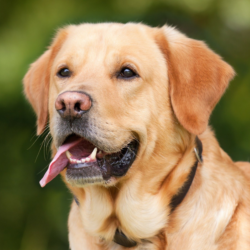

In [12]:
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)
image = to_pil(img_t)
image

In [13]:
batch_t = torch.unsqueeze(img_t, 0)
resnet.eval()
out = resnet(batch_t)
print(out.shape)


torch.Size([1, 1000])


In [14]:
resnet.eval()
out = resnet(batch_t)
_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
[(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]


[(b"208: 'Labrador retriever',", 80.53568267822266),
 (b"207: 'golden retriever',", 11.078383445739746),
 (b"209: 'Chesapeake Bay retriever',", 3.9604055881500244),
 (b"222: 'kuvasz',", 1.3174304962158203),
 (b"159: 'Rhodesian ridgeback',", 0.3191797435283661)]

Lovely! Our dog is easily identified by Resnet.

## Large Dataset Example

Now we can try this same workflow on a large set of images.

### A Few Tips

So, if you are going to run any processes on the cluster, you need all your objects over there - this lets your workers do all the tasks without reaching out to other workers or the client. However, if you use a functional setup (as we are going to do later) you'll need to do this INSIDE your function. Our architecture below will have all that written in. But before we go too complex, we should learn how that works in isolation.

This command is all you need to move an object (a model, an image, etc) to the cluster. So here's how we do it with the model:

In [15]:
resnet = resnet.to(device)

And here's how we do it with an image. (Already processed to tensor.)

In [16]:
img_t = img_t.to(device)

## Inference

Now we are ready to proceed with our batch dog identification! 

In [17]:
client.restart()
client

Client Scheduler: tcp://d-steph-resnet-article.main-namespace:8786 Dashboard: https://d-steph-resnet-article.internal.saturnenterprise.io,Cluster Workers: 4 Cores: 128 Memory: 510.00 GB


***

## 1. Process Inference with Futures

In this first example, the pipeline runs in parallel for each image. This approach allows you to use very standard pythonic code and not think too much about the cluster - you write your code to accept an image path, and then it will output the prediction results.

In [45]:
@dask.delayed
def process_one(path, fs=__builtins__):
    transform = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(250), 
        transforms.ToTensor()])

    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        nvis = transform(img)

    truth = re.search('dogs/Images/n[0-9]+-([^/]+)/n[0-9]+_[0-9]+.jpg', path).group(1)
    name = re.search('dogs/Images/n[0-9]+-[a-zA-Z-_]+/(n[0-9]+_[0-9]+).jpg', path).group(1)
    
    return [name, nvis, truth]

def evaluate_pred(batch, gtruth, classes):
    ''' Accepts images, returns human readable predictions. '''
    _, indices = torch.sort(batch, descending=True)
    percentage = torch.nn.functional.softmax(batch, dim=1)[0] * 100
    pred = [(classes[idx], percentage[idx].item()) for idx in indices[0]]
    labs = gtruth
    return(pred[:1], labs)

def get_truth_name(name):
    ''' Transforms the ground truth name to remove unwanted numeric prefix. '''
    x = re.search('^[^_]*-(.*)$', name).group(1)
    return(x)

def is_match(la, ev):
    ''' Evaluate human readable prediction against ground truth. 
    (Used in both methods)'''
    if re.search(la.replace('_', ' '), str(ev).replace('_', ' ')):
        match = True
    else:
        match = False
    return(match)     


@dask.delayed
def run_batch_pipeline(iteritem):
    ''' Accepts iterable result of preprocessing, generates inferences and evaluates. '''
    
    with s3.open('s3://dask-datasets/dogs/imagenet1000_clsidx_to_labels.txt') as f:
        classes = [line.strip() for line in f.readlines()]
  
    names, images, truelabels = iteritem
    img_t = torch.unsqueeze(images, 0)
    with torch.no_grad():
        # Set up model
        resnet = models.resnet50(pretrained=True)
        resnet = resnet.to(device)
        resnet.eval()

        # run model on batch
        img_t = img_t.to(device)
        pred_batch = resnet(img_t)

        #Evaluate batch
        preds, labslist = evaluate_pred(pred_batch, truelabels, classes)

        #Organize prediction results
        predicted = preds
        groundtruth = labslist
        name = names
        match = is_match(groundtruth, predicted)

        outcome = (name, groundtruth, predicted, match)
        
        return(outcome)


In [46]:
s3fpath

's3://dask-datasets/dogs/Images/*/*.jpg'

Here we map the function to all the file paths for all the images, and distribute tasks across cluster in the form of futures. The `.gather()` step will compute those futures.

In [47]:
%%time
lists = [process_one(x, fs=s3) for x in s3.glob(s3fpath)]

CPU times: user 3.92 s, sys: 116 ms, total: 4.03 s
Wall time: 7.03 s


In [48]:
%%time
futures1 = client.map(run_batch_pipeline, lists)
result1 = client.gather(futures1)

CPU times: user 41.3 s, sys: 440 ms, total: 41.7 s
Wall time: 1min 2s


In [49]:
%%time
r1 = client.compute(result1)

CPU times: user 1min 10s, sys: 37.2 ms, total: 1min 10s
Wall time: 1min 10s


In [51]:
len(r1)

20580

In [ ]:
%%time
test1b = [x.result() for x in r1[:5000]]
# test1b

***


In [52]:
client.restart()
client

Client Scheduler: tcp://d-steph-resnet-article.main-namespace:8786 Dashboard: https://d-steph-resnet-article.internal.saturnenterprise.io,Cluster Workers: 4 Cores: 128 Memory: 510.00 GB


## 2. Process Batches of Inferences

This approach uses a similar technique but lets us distribute tasks across nodes more efficiently. This will dramatically accelerate the process, but requires a little more work adapting the code to accepting batches of images.

In [39]:
@dask.delayed
def process_one(path, fs=__builtins__):
    transform = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(250), 
        transforms.ToTensor()])

    try:
        with fs.open(path, 'rb') as f:
            img = Image.open(f).convert("RGB")
            nvis = transform(img)
    except:
        nvis = path
    truth = re.search('dogs/Images/n[0-9]+-([^/]+)/n[0-9]+_[0-9]+.jpg', path).group(1)
    name = re.search('dogs/Images/n[0-9]+-[a-zA-Z-_]+/(n[0-9]+_[0-9]+).jpg', path).group(1)
    
    return [name, nvis, truth]

@dask.delayed
def reformat(batch):
    flat_list = [item for item in batch]
    tensors = [x[1] for x in flat_list]
    names = [x[0] for x in flat_list]
    labels = [x[2] for x in flat_list]
    return [names, tensors, labels]

def evaluate_pred_batch(batch, gtruth, classes):
    ''' Accepts batch of images, returns human readable predictions. '''
    _, indices = torch.sort(batch, descending=True)
    percentage = torch.nn.functional.softmax(batch, dim=1)[0] * 100
    
    preds = []
    labslist = []
    for i in range(len(batch)):
        pred = [(classes[idx], percentage[idx].item()) for idx in indices[i][:1]]
        preds.append(pred)

        labs = gtruth[i]
        labslist.append(labs)
        
    return(preds, labslist)

def get_truth_name(name):
    ''' Transforms the ground truth name to remove unwanted numeric prefix. '''
    x = re.search('^[^_]*-(.*)$', name).group(1)
    return(x)

def is_match(la, ev):
    ''' Evaluate human readable prediction against ground truth. 
    (Used in both methods)'''
    if re.search(la.replace('_', ' '), str(ev).replace('_', ' ')):
        match = True
    else:
        match = False
    return(match)


@dask.delayed
def run_batch_pipeline(iteritem):
    ''' Accepts iterable result of preprocessing, generates inferences and evaluates. '''
    
    with s3.open('s3://dask-datasets/dogs/imagenet1000_clsidx_to_labels.txt') as f:
        classes = [line.strip() for line in f.readlines()]
  
    names, images, truelabels = iteritem
    images = torch.stack(images)
    with torch.no_grad():
        # Set up model
        resnet = models.resnet50(pretrained=True)
        resnet = resnet.to(device)
        resnet.eval()

        # run model on batch
        images = images.to(device)
        pred_batch = resnet(images)

        #Evaluate batch
        preds, labslist = evaluate_pred_batch(pred_batch, truelabels, classes)

        #Organize prediction results
        results = []
        for j in range(0, len(images)):
            predicted = preds[j]
            groundtruth = labslist[j]
            name = names[j]
            match = is_match(groundtruth, predicted)

            outcome = (name, groundtruth, predicted, match)
            results.append(outcome)
        
        return(results)

In [40]:
%%time

batch_breaks = [list(batch) for batch in toolz.partition_all(60, s3.glob(s3fpath))]
lists2 = [[process_one(x, fs=s3) for x in y] for y in batch_breaks]
refactored2 = [reformat(result) for result in lists2]

CPU times: user 4.07 s, sys: 145 ms, total: 4.22 s
Wall time: 8.45 s


In [41]:
%%time
futures2 = client.map(run_batch_pipeline, refactored2)
test2 = client.gather(futures2)

CPU times: user 1.6 s, sys: 16.2 ms, total: 1.61 s
Wall time: 2.84 s


Look how much faster we made the job! That's the kind of thing that Dask and GPUs can make possible.

In [42]:
%%time
final2 = compute(test2)

CPU times: user 37.8 s, sys: 320 ms, total: 38.1 s
Wall time: 3min 55s


In [ ]:
#final2

***

## Test the model's performance

The two methods should return the same results, and we can test to prove it.

In [60]:
pups1=test1

print(f'Number of dog photos examined: {len(pups1)}')

accurate = [x[3] for x in pups1 if x[3] == True]
print(f'Number of dogs classified correctly: {len(accurate)}')

pct_cor = (len(accurate)/len(pups1))*100 
print(f'The percent of dogs classified correctly: {round(pct_cor,3)}%')


Number of dog photos examined: 20580
Number of dogs classified correctly: 13802
The percent of dogs classified correctly: 67.065%


In [71]:
# For batch
pups2 = final2[0]

# puplen = sum([len(x) for x in pups2]) 
puplen = [y for x in pups2 for y in x]
print(f'Number of dog photos examined: {len(puplen)}')
accurate = [y for x in pups2 for y in x if y[3] == True]

print(f'Number of dogs classified correctly: {len(accurate)}')

pct_cor = (len(accurate)/len(puplen))*100 
print(f'The percent of dogs classified correctly: {round(pct_cor,3)}%')

Number of dog photos examined: 20580
Number of dogs classified correctly: 13802
The percent of dogs classified correctly: 67.065%


In [75]:
pups1[10:15]

[('n02085620_1152',
  'Chihuahua',
  [(b"151: 'Chihuahua',", 94.77488708496094)],
  True),
 ('n02085620_11696',
  'Chihuahua',
  [(b"151: 'Chihuahua',", 87.93510437011719)],
  True),
 ('n02085620_11818',
  'Chihuahua',
  [(b"151: 'Chihuahua',", 77.83676147460938)],
  True),
 ('n02085620_11948',
  'Chihuahua',
  [(b"285: 'Egyptian cat',", 12.356023788452148)],
  False),
 ('n02085620_1205',
  'Chihuahua',
  [(b"151: 'Chihuahua',", 99.17437744140625)],
  True)]

Fantastic! You'll notice that the cases where the model is wrong are often low likelihood percentages as well, which is what we would expect to see.

## Save Results

The last thing we want to do, then, is save our results to S3 for later use.

In [38]:
flat_list = [item for sublist in test3 for item in sublist]

In [39]:
flat_list = [item for item in flat_list]

In [ ]:
flist = pd.DataFrame(flat_list)
flist.to_csv("test/dog_model_results.csv", index = False, header = ['ground_truth','prediction','evaluation'])

In [ ]:
s3.put('/home/jovyan/project/test/dog_model_results.csv', 's3://dask-datasets/dogs/dog_model_results.csv')